<img width="100" src="https://carbonplan-assets.s3.amazonaws.com/monogram/dark-small.png" style="margin-left:0px;margin-top:20px"/>

# Exploring additional tonyear approaches implemented by the Climate Action Reserve and the government of Quebec

_by Freya Chay (CarbonPlan)_

This notebook introduces our implementation of the ton-year methods used by the Climate Action
Reserve (CAR) and proposed by the government of Quebec (QC).

We also compare the replicated methods to the implementation of the Lashof method in the `tonyear`
package.

Sources:

- [Climate Action Reserve Soil Enrichment Protocol (2020)](https://www.climateactionreserve.org/wp-content/uploads/2020/10/Soil-Enrichment-Protocol-V1.0.pdf)
- [Quebec draft ton-year methodology (2021)](https://www.environnement.gouv.qc.ca/changements/carbone/credits-compensatoires/quebec-protocole-foret-en.pdf)


In [1]:
%load_ext watermark
%matplotlib inline

import math

import numpy as np
import matplotlib.pyplot as plt

import tonyear

from carbonplan import styles
styles.mpl.set_theme(style='carbonplan_light', font_scale=1.25)

In [2]:
%watermark -u -i -v -m -g -iv

Last updated: 2022-02-11T02:08:08.082188+00:00

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.10.2

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 5.4.129+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

Git hash: 107727a042048adac87cb41d23ea860b08f633ab

carbonplan: 0.4.0
tonyear   : 1.0.0.post15
matplotlib: 3.4.3
numpy     : 1.20.3



## Comparing the CAR and Quebec methods to Lashof


If you aren't familiar with the Lashof method or the concept of an 'equivalence ratio', please take
a minute to check out our
[ton-year explainer article](https://carbonplan.org/research/ton-year-explainer). In brief, the
equivalence ratio describes how many tons of CO₂ need to be temporarily stored to justify an
additional ton of CO₂ emitted to the atmosphere today under a given set of assumptions.

The Lashof method calculates the benefit of temporary carbon storage by asking how many ton-years of
atmospheric impact are avoided as a result of the carbon storage. To do so, the Lashof method looks
looks both at the ton-year benefit of the carbon storage and at the ton-year cost of re-emission
after the storage period ends.

Neither the CAR nor Quebec methods explicitly consider the ton-year cost of re-emission. We can
compare the equivalence ratios generated by these methods to the equivalence ratios generated by the
Lashof method get a sense of how much temporary carbon storage might be overvalued as a result.

Both the CAR and Quebec methods are explored in more detail below.


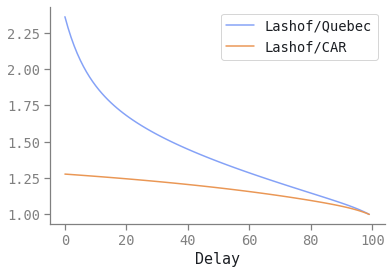

In [3]:
curve = tonyear.get_baseline_curve("joos_2013")
delays = np.arange(1, 101)
time_horizon = 100
discount_rate = 0

equivalence_lashof = [
    tonyear.calculate_tonyears("lashof", curve, time_horizon, delay, discount_rate)[
        "num_for_equivalence"
    ]
    for delay in delays
]
equivalence_car = [
    tonyear.calculate_tonyears("car", curve, time_horizon, delay, discount_rate)[
        "num_for_equivalence"
    ]
    for delay in delays
]
equivalence_qc = [
    tonyear.calculate_tonyears("qc", curve, time_horizon, delay, discount_rate)[
        "num_for_equivalence"
    ]
    for delay in delays
]

plt.plot(np.array(equivalence_lashof) / np.array(equivalence_qc), label="Lashof/Quebec")
plt.plot(np.array(equivalence_lashof) / np.array(equivalence_car), label="Lashof/CAR")

plt.xlabel("Delay")
plt.legend()
plt.show()

While all three methods converge on 100 years of carbon storage being equivalent to a 1 tCO2
emission, they diverge for shorter storage periods.

The Quebec method, in particular, values temporary storage more than the Lashof method — and the
shorter the storage period, the more significant the difference. This effect occurs because the
Quebec method focuses on the “benefit” of avoiding radiative forcing over the storage period, but
does not take into account the radiative forcing “cost” that occurs when CO2 is reemitted at the end
of the storage period. (The Lashof method more appropriately counts both elements.)

To give a more specific example, we can compare how tCO2 stored for 1 year each method would require
for equivalence.


In [4]:
print(f"Lashof requires:   {round(equivalence_lashof[0])} tCO2 stored for 1 year")
print(f"CAR requires:      {round(equivalence_car[0])} tCO2 stored for 1 year")
print(f"Quebec requires:   {round(equivalence_qc[0])} tCO2 stored for 1 year")
print()

Lashof requires:   128 tCO2 stored for 1 year
CAR requires:      100 tCO2 stored for 1 year
Quebec requires:   54 tCO2 stored for 1 year



## The Climate Action Reserve method


The Climate Action Reserve (CAR) ton-year method calculates the benefit of temporary carbon storage
by (1) defining the duration of carbon storage considered equivalent to an emission and (2) awarding
proportional credit linearly over the time horizon for more temporary storage.

CAR specifically defines 100 year storage as "completely mitigat[ing] an equal GHG emission
elsewhere." In other words, CAR claims that storing 1 tCO2 for 100 years (100 ton-years of storage)
is equivalent to a 1 tCO2 emission. Storing 1 tCO2 for 1 years (1 ton-years) would only provide
1/100th of the benefit needed for equivalence. Similarly, storing 1 tCO2 for 20 years (20 ton-years)
would provide 1/5th of the benefit needed for equivalence.

The CAR ton year accounting method is in the Soil Enrichment Protocol (V1) in section 3.5.5:
https://www.climateactionreserve.org/wp-content/uploads/2020/10/Soil-Enrichment-Protocol-V1.0.pdf

We show two examples of the `tonyear` module's calculations below for CAR's method with a 100 year
time horizon.


In [5]:
time_horizon = 100
discount_rate = 0
delay = 1
baseline = tonyear.get_baseline_curve("joos_2013")

tonyear.print_benefit_report(
    tonyear.calculate_tonyears("car", baseline, time_horizon, delay, discount_rate)
)


Discount rate: 0%
Delay: 1 year(s)
Baseline atmospheric cost: 52.36 ton-years
Benefit from 1tCO2 with delay: 0.52 ton-years
Number needed: 100.0



In [6]:
time_horizon = 100
discount_rate = 0
delay = 30
baseline = tonyear.get_baseline_curve("joos_2013")

tonyear.print_benefit_report(
    tonyear.calculate_tonyears("car", baseline, time_horizon, delay, discount_rate)
)


Discount rate: 0%
Delay: 30 year(s)
Baseline atmospheric cost: 52.36 ton-years
Benefit from 1tCO2 with delay: 15.71 ton-years
Number needed: 3.3



In essence, the CAR method awards benefit linearly over the chosen time_horizon.


## Proposed Quebec method


The governement of Quebec (specifically the Ministère de l’Environnement et de la Lutte contre les
changements climatiques) has published a draft ton-year accounting method which (as of
February 2022) is
[presented](https://www.environnement.gouv.qc.ca/changements/carbone/credits-compensatoires/index-en.htm#developing-regulations-work)
as a work in progress to "allow more offset credit projects to be carried out and to increase the
supply of Québec credits..." The proposed method calculates the benefit of temporary carbon storage
by (1) defining the duration of carbon storage considered equivalent to an emission and (2) awarding
credit over the time horizon in proportion to the shape of the IRF curve.

The Quebec method is described in a slide deck presenting the draft ton-year accounting approach:
https://www.environnement.gouv.qc.ca/changements/carbone/credits-compensatoires/quebec-protocole-foret-en.pdf

We show an example of the `tonyear` module's implementation of Quebec method below.


In [7]:
time_horizon = 100
discount_rate = 0
delay = 30
baseline = tonyear.get_baseline_curve("joos_2013")

qc = tonyear.calculate_tonyears("qc", baseline, time_horizon, delay, discount_rate)
tonyear.print_benefit_report(qc)
percent_credit = round(qc["benefit"] / qc["baseline_atm_cost"], 1)
print(
    f"--> {qc['parameters']['delay']} year delay corresponds to {percent_credit*100}% of a credit"
)
print()


Discount rate: 0%
Delay: 30 year(s)
Baseline atmospheric cost: 52.36 ton-years
Benefit from 1tCO2 with delay: 19.96 ton-years
Number needed: 2.6

--> 30 year delay corresponds to 40.0% of a credit



In essence, the Quebec method awards benefit in proportion to the shape of the IRF curve used to
approximate the radiative forcing effect resulting from a CO2 emission in the atmosphere.


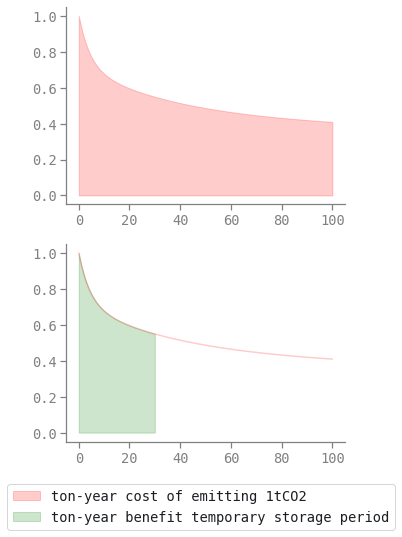

In [8]:
t = np.arange(qc["parameters"]["time_horizon"] + 1)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5, 8))

ax[0].fill_between(
    t,
    qc["baseline"],
    color="red",
    alpha=0.2,
    label="ton-year cost of emitting 1tCO2",
)

delay = qc["parameters"]["delay"]
time_horizon = qc["parameters"]["time_horizon"]

ax[1].plot(qc["baseline"], color="red", alpha=0.2)
ax[1].fill_between(
    t,
    qc["baseline"],
    where=(t <= qc["parameters"]["delay"]),
    color="green",
    alpha=0.2,
    label="ton-year benefit temporary storage period",
)

handles = []
labels = []
for ax in fig.axes:
    ax_handles, ax_labels = ax.get_legend_handles_labels()
    handles.extend(ax_handles)
    labels.extend(ax_labels)
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.04))
plt.show()